In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

from lightgbm import LGBMClassifier

import tensorflow as tf
import tensorflow_hub as hub

from transformers import BertTokenizer

print(tf.__version__)

2.4.1


In [2]:
data_path = '../files/'

In [3]:
df = pd.read_csv(data_path+'progress/df.csv')
test_df = pd.read_csv(data_path+'progress/test_df.csv')
print(df.shape, test_df.shape)

(6861, 7) (3263, 7)


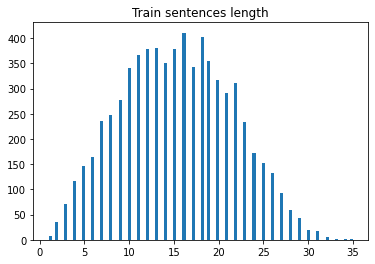

In [4]:
def plot_sent_len(dataf, col, title):
    dataf['len_' + col] = dataf[col].apply(lambda txt: len(txt.split()))
    plt.hist(dataf['len_' + col], bins = 100)
    plt.title('Train sentences length')
    plt.show()
    return dataf

col = 'ctext'
df = plot_sent_len(df, col, 'sentence lengths')

In [5]:
train_txts, val_txts, y_train, y_val = train_test_split(
    df[col].values, df['target'].values,
    shuffle = True, test_size = 0.15,
    stratify = df['target'].values,
)
test_txts = test_df[col].values
y_test = test_df['target'].values
print('Train size:', train_txts.shape)
print('Validation size:', val_txts.shape)
print('Test size:', test_txts.shape)

Train size: (5831,)
Validation size: (1030,)
Test size: (3263,)


In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [7]:
def tokenize_txts(txts, max_len = 40):
    res = tokenizer(
        text = [tokenizer.tokenize(txt) for txt in txts],
        max_length = max_len,
        padding = 'max_length',
        truncation = True,
        is_split_into_words = True,
    )
    return {
        'input_word_ids': res['input_ids'],
        'input_mask': res['attention_mask'],
        'input_type_ids': res['token_type_ids'],
    }

def detokenize_txt(token):
    res = tokenizer.decode(token)
    return res

In [8]:
MAX_LEN = 35
BATCH_SIZE = 32

In [9]:
train_tokens = tokenize_txts(train_txts, MAX_LEN)
val_tokens = tokenize_txts(val_txts, MAX_LEN)
test_tokens = tokenize_txts(test_txts, MAX_LEN)

In [10]:
print('Orginal txt: ', train_txts[0])
print()
sample = train_tokens['input_word_ids'][0]
print('Tokenized txt:', sample)
print()
print('Detokenizd txt:', detokenize_txt(sample))

Orginal txt:  so if i capsize on your thighs high tide b number you sunk my battleship

Tokenized txt: [101, 2061, 2065, 1045, 9700, 1001, 1001, 1045, 4371, 2006, 2115, 9222, 2152, 10401, 1038, 2193, 2017, 10417, 2026, 17224, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Detokenizd txt: [CLS] so if i caps # # ize on your thighs high tide b number you sunk my battleship [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [37]:
train_txts[0]

'so if i capsize on your thighs high tide b number you sunk my battleship'

In [36]:
train_txts[3]

'some poor sods arriving in amman during yesterday is dust storm were diverted to ben gurion airport url'

In [16]:
train_tokens.keys()

dict_keys(['input_word_ids', 'input_mask', 'input_type_ids'])

In [21]:
print(train_tokens['input_word_ids'][0])
print(train_tokens['input_mask'][0])
print(train_tokens['input_type_ids'][0])

[101, 2061, 2065, 1045, 9700, 1001, 1001, 1045, 4371, 2006, 2115, 9222, 2152, 10401, 1038, 2193, 2017, 10417, 2026, 17224, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [32]:
print(train_tokens['input_word_ids'][3])
print(train_tokens['input_mask'][3])
print(train_tokens['input_type_ids'][3])

[101, 2070, 3532, 2061, 1001, 1001, 16233, 7194, 1999, 25703, 2076, 7483, 2003, 6497, 4040, 2020, 18356, 2000, 3841, 19739, 1001, 1001, 5673, 2078, 3199, 24471, 1001, 1001, 1048, 102, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [22]:
sum(train_tokens['input_mask'][0])

21

In [38]:
train_ds = tf.data.Dataset.from_tensor_slices((train_tokens, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((val_tokens, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((test_tokens, y_test))

train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

In [41]:
train_ds

<BatchDataset shapes: ({input_word_ids: (None, 35), input_mask: (None, 35), input_type_ids: (None, 35)}, (None,)), types: ({input_word_ids: tf.int32, input_mask: tf.int32, input_type_ids: tf.int32}, tf.int64)>

In [39]:
class MyF1(tf.keras.metrics.Metric):
    def __init__(self, name = 'mf1_score'):
        super(MyF1, self).__init__(name)
        self.p = tf.metrics.Precision()
        self.r = tf.metrics.Recall()
        self.f1 = self.add_weight(name="f1", initializer="zeros")
    
    def update_state(self, actual, predicted, sample_weight = None):
        self.p.update_state(actual, predicted)
        self.r.update_state(actual, predicted)
        self.f1.assign(2 * self.p.result() * self.r.result() / (self.p.result() + self.r.result()))
        
    def reset_states(self, ):
        self.p.reset_states()
        self.r.reset_states()
        self.f1.assign(0.0)
    def result(self,):
        return self.f1    

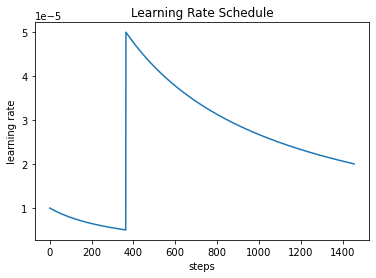

In [40]:
class CSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, lr, freeze_epoch ,batch_size, data_size):
        super(CSchedule, self).__init__()
        self.lr = lr
        self.bs = batch_size
        self.ds = data_size
        self.freeze_epoch = freeze_epoch

    def __call__(self, step):
        epoch = step /(self.ds / self.bs) + 1
        if not self.freeze_epoch or epoch < self.freeze_epoch:
            return self.lr / (tf.cast(epoch, tf.float32)+1)
        else:
            return self.lr * 10 / (tf.cast(epoch, tf.float32)+1)
        
clr = CSchedule(2e-5, 3, BATCH_SIZE, len(train_txts))
plt.plot([clr(x) for x in tf.range(1, 1457, dtype=tf.float32)])
plt.xlabel('steps')
plt.ylabel('learning rate')
plt.title('Learning Rate Schedule')
plt.show()

In [42]:
bert_handler = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'

In [43]:
class MClassifier(tf.keras.Model):
    def __init__(self, dropout_rate):
        super(MClassifier, self).__init__()
        
        self.bert_layer = hub.KerasLayer(
            bert_handler,
            name = 'feature_ext',
            trainable = True,
        )
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.proba = tf.keras.layers.Dense(1, activation = 'sigmoid')

    def call(self, X_in, training):
        x = self.bert_layer(X_in, training = training)
        x = x['pooled_output']
        x = self.dropout(x, training = training)
        output = self.proba(x)
        return output

In [44]:
LEARNING_RATE = 2e-5
EPOCHS = 5
DP_RATE = 0.3

loss_objective = tf.keras.losses.BinaryCrossentropy()

In [45]:
def model_evaluation(model, ds, name):
    acc = tf.keras.metrics.BinaryAccuracy()
    f1 = MyF1()
    total_loss = []
    y_hats = []
    for X, y in ds:
        y_hat = model(X, training = False)
        loss = loss_objective(y, y_hat)
        acc.update_state(y, y_hat)
        f1.update_state(y, y_hat)
        total_loss.append(loss.numpy())
        y_hats.append(y_hat)
    y_hats = tf.concat(y_hats, axis = 0).numpy()
    print(f'{name}, loss {np.mean(total_loss):.3f}, acc {acc.result().numpy():.3f}, f1 {f1.result().numpy():.3f}')
    return y_hats, acc.result().numpy(), f1.result().numpy()

In [46]:
@tf.function
def train_step(model, tr_vars, X, y):
    with tf.GradientTape() as tape:
        y_hat = model(X, training = True)
        loss = loss_objective(y, y_hat)
    grads = tape.gradient(loss, tr_vars)
    return loss, grads, y_hat

def train_model(model, epochs, freeze_bert_on_epoch = None):
    clr = CSchedule(LEARNING_RATE, freeze_bert_on_epoch, BATCH_SIZE, len(train_txts))
    optimizer = tf.keras.optimizers.Adam(clr)
    acc = tf.keras.metrics.BinaryAccuracy()
    f1 = MyF1()
    for epoch in range(1, epochs + 1):
        
        if freeze_bert_on_epoch is not None and epoch == freeze_bert_on_epoch:
            model.get_layer('feature_ext').trainable = False
            
        acc.reset_states()
        f1.reset_states()
        total_loss = []
        for X, y in train_ds:
            tr_vars = model.trainable_variables
            loss, grads, y_hat = train_step(model, tr_vars, X, y)
            optimizer.apply_gradients(zip(grads, tr_vars))
            acc.update_state(y, y_hat)
            f1.update_state(y, y_hat)
            total_loss.append(loss.numpy())
            
        print(f'epoch {epoch}, loss {np.mean(total_loss):.3f}, acc {acc.result().numpy():.3f}, f1 {f1.result().numpy():.3f}')
        model_evaluation(model, val_ds, 'val')
        print()
        
    y_test_hat, _, _ = model_evaluation(model, test_ds, 'test')
    return y_test_hat

In [ ]:
model = MClassifier(DP_RATE,)
y_test_hat = train_model(model, EPOCHS, freeze_bert_on_epoch = 3)

INFO:absl:Using C:\Users\alba_\AppData\Local\Temp\tfhub_modules to cache modules.


epoch 1, loss 0.538, acc 0.731, f1 0.650
val, loss 0.398, acc 0.833, f1 0.776



In [ ]:
y_model_hat = np.array([1 if x[0] >0.5 else 0 for x in y_test_hat])
print(classification_report(y_test, y_model_hat))

In [ ]:
def plot_embedding(X, y):
    colors = ['green', 'red']
    labels = ['NoDisastor', 'Disastor']
    proj = PCA(2)
    proj_X = proj.fit_transform(X)
    for y_id in np.unique(y):
        plt.scatter(
            x = proj_X[y == y_id, 0], 
            y = proj_X[y == y_id, 1],
            s = 4,
            label = labels[y_id],
            c = colors[y_id], 
            alpha = 0.4
        )
        plt.xlabel('X1')
        plt.ylabel('X2')
        plt.legend()

def plot_embeddings(pooled, seq, mean_max, y, title):
    fig = plt.figure(figsize = (12, 4))
    plt.subplot(1, 3 ,1 )
    plot_embedding(pooled, y)
    plt.title(f'Pooled output in {title} dataset')
    
    plt.subplot(1, 3 ,2)
    plot_embedding(seq, y)
    plt.title(f'Mean hidden state in {title} dataset')
    
    plt.subplot(1, 3 ,3)
    plot_embedding(mean_max, y)
    plt.title(f'MeanMax hidden state in {title} dataset')
    plt.show()
    
def accumulate_embeddings(model, ds):
    embedder = model.get_layer('feature_ext')
    pooled_list = []
    seq_list = []
    for X, y in ds:
        output = embedder(X,)
        pooled_output = output['pooled_output'].numpy()
        seq_output = output['sequence_output'].numpy()
        pooled_list.append(pooled_output)
        seq_list.append(seq_output)
    pooled_list = tf.concat(pooled_list, axis = 0).numpy()
    seq_list = tf.concat(seq_list, axis = 0).numpy()
    return pooled_list, np.mean(seq_list, axis = 1), np.mean(seq_list, axis = 1) + np.max(seq_list, axis = 1)

In [ ]:
tr_pooled, tr_seq, tr_mean_max = accumulate_embeddings(model, train_ds,)
plot_embeddings(tr_pooled, tr_seq,tr_mean_max, y_train, 'Train')

val_pooled, val_seq, val_mean_max = accumulate_embeddings(model, val_ds,)
plot_embeddings(val_pooled, val_seq,val_mean_max, y_val, 'Valid')

test_pooled, test_seq, test_mean_max = accumulate_embeddings(model, test_ds,)
plot_embeddings(test_pooled, test_seq, test_mean_max, y_test, 'Test')

In [ ]:
def train_gbm_cls(X_tr, y_tr, X_val, y_val, X_test, y_test):
    gbm_cls = LGBMClassifier(
        objective = 'binary',
        class_weight = 'balanced'
    )
    gbm_cls.fit(
        X_tr, y_tr,
        eval_set = (X_val, y_val),
        early_stopping_rounds = 20,
        verbose = 0,
    )
    print('Train')
    print(classification_report(y_train, gbm_cls.predict(X_tr)))
    print('Validation')
    print(classification_report(y_val, gbm_cls.predict(X_val)))
    print('Test')
    gbm_y_hat = gbm_cls.predict(X_test)
    print(classification_report(y_test, gbm_y_hat))
    return gbm_cls, gbm_y_hat

train_feat = tr_mean_max
val_feat = val_mean_max
test_feat = test_mean_max

gbm_cls, gbm_y_hat = train_gbm_cls(train_feat, y_train, val_feat, y_val , test_feat, y_test)

In [ ]:
sub = pd.DataFrame(columns = ['id', 'target'])
sub['id'] = test_df.id
sub['target'] = gbm_y_hat
sub.to_csv('sub.csv', index = False)

In [ ]:
nsub = pd.DataFrame(columns = ['id', 'target'])
nsub['id'] = test_df.id
nsub['target'] = y_model_hat
nsub.to_csv('nsub.csv', index = False)